# Usage Guide - Optimal Binning Points Under Monotonicity Constraints

This Jupyter Notebook introduces an innovative approach to determining optimal binning points under monotonicity constraints with respect to a binary response variable, specifically tailored for Weight of Evidence (WoE) transformation in logistic regression models. This method ensures that the generated bins maintain a logical and consistent relationship with the response variable, facilitating future model interpretability.

### Dataset and Context

The data used in this notebook is synthetic, sourced from Kaggle ([Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data?select=credit_risk_dataset.csv)), and is situated in the context of credit risk. While the dataset is simplified, the methodology presented here is applicable to real-world datasets across various industries. The only prerequisites are a binary response variable and the intention to model using WoE in a logistic regression framework :)

### Methodology Overview

This approach accommodates the definition of special values and handles missing values effectively. It is important to note that no additional preprocessing or transformation will be applied to the variables; the method is exclusively designed for numerical variables. However, categorical variables are also included in this notebook to demonstrate how the provided functions can calculate WoE values and summarize them for categorical data.

### Dataset Description

The columns in the dataset and their respective descriptions are as follows:

- **person_age**: Age  
- **person_income**: Annual income  
- **person_home_ownership**: Type of home ownership  
- **person_emp_length**: Employment length (in years)  
- **loan_intent**: Purpose of the loan  
- **loan_grade**: Credit grade of the loan  
- **loan_amnt**: Loan amount  
- **loan_int_rate**: Loan interest rate  
- **loan_percent_income**: Loan amount as a percentage of income  
- **cb_person_default_on_file**: History of default  
- **cb_person_cred_hist_length**: Credit history length  
- **loan_status**: Loan status (Target: 0 = non-default, 1 = default)

### Variables Used in this Notebook

The notebook focuses on the following numerical and categorical variables:

#### Numerical Variables:
- **person_age**  
- **person_income**  
- **loan_amnt**  
- **loan_int_rate**  
- **loan_percent_income**

#### Categorical Variables:
- **cb_person_default_on_file**  
- **loan_grade**  
- **person_home_ownership**  
- **loan_intent**

This notebook serves as a comprehensive guide for implementing monotonicity-constrained binning and WoE transformations. It demonstrates the practical application of custom-designed functions, developed by me and imported from an external module (`funciones.py`), which streamline the process of calculating WoE values and summarizing results for numerical and categorical variables. By following the example provided, users can effectively apply these methods to their own datasets, ensuring consistency and interpretability in logistic regression models.

## 0. Preliminaries

### 0.1. Import libreries and load dataset

In [1]:
# Standard libraries
import os
import warnings

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# custom functions - optimal binning
from functions import *

# Set working directory and configurations
os.chdir('C:/Projects/Optimal_WoE')
np.random.seed(2357)
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('credit_risk_dataset.csv')
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [3]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [4]:
df.isna().mean()

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027470
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095639
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [5]:
# Choose numerical and categorical variables
num_columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']

cat_columns = ['cb_person_default_on_file', 'loan_grade', 'person_home_ownership', 'loan_intent']

df = df[num_columns + cat_columns + ['loan_status']]
df

,person_age,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,loan_grade,person_home_ownership,loan_intent,loan_status
0,22,59000,35000,16.02,0.59,Y,D,RENT,PERSONAL,1
1,21,9600,1000,11.14,0.10,N,B,OWN,EDUCATION,0
2,25,9600,5500,12.87,0.57,N,C,MORTGAGE,MEDICAL,1
3,23,65500,35000,15.23,0.53,N,C,RENT,MEDICAL,1
4,24,54400,35000,14.27,0.55,Y,C,RENT,MEDICAL,1
...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,5800,13.16,0.11,N,C,MORTGAGE,PERSONAL,0
32577,54,120000,17625,7.49,0.15,N,A,MORTGAGE,PERSONAL,0
32578,65,76000,35000,10.99,0.46,N,B,RENT,HOMEIMPROVEMENT,1
32579,56,150000,15000,11.48,0.10,N,B,MORTGAGE,PERSONAL,0


### 0.2. Add missing and special values

In this section, we simulate missing values and special values in the numerical variables of the dataset. Missing values are added to between 10% and 30% of each numerical variable. Additionally, up to 10% of special values are introduced into some numerical columns, excluding the missing values.

This step allows us to demonstrate how the functions handle missing and special values during the binning process.

In [6]:
# Add missing values and special values to numerical columns
# Missing values: 10%-30% of each numerical column
# Special values: Assign values like -6666 or -9999 to specific percentages of columns

# Loop to add missing values (NaN) to numerical columns
for col in num_columns:
    N_nan = int(len(df) * np.random.uniform(0.1, 0.3))
    index_nan = np.random.choice(df.index, N_nan, replace=False)
    df.loc[index_nan, col] = np.nan

# Loop to add special values to specific numerical columns
for col, value, percentage in [
    ('person_income', -6666, 0.1),
    ('loan_amnt', -9999, 0.1),
    ('loan_int_rate', -6666, 0.05),
    ('loan_int_rate', -9999, 0.05),
    ('loan_percent_income', -9999, 0.07)
]:
    N_special = int(len(df) * percentage)
    valid_index = df[df[col].isna() == False].index
    index_special = np.random.choice(valid_index, N_special, replace=False)
    df.loc[index_special, col] = value

df

,person_age,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,loan_grade,person_home_ownership,loan_intent,loan_status
0,22.0,59000.0,35000.0,16.02,0.59,Y,D,RENT,PERSONAL,1
1,21.0,9600.0,-9999.0,-9999.00,NaN,N,B,OWN,EDUCATION,0
2,NaN,9600.0,5500.0,12.87,0.57,N,C,MORTGAGE,MEDICAL,1
3,23.0,65500.0,35000.0,NaN,0.53,N,C,RENT,MEDICAL,1
4,24.0,NaN,35000.0,14.27,-9999.00,Y,C,RENT,MEDICAL,1
...,...,...,...,...,...,...,...,...,...,...
32576,57.0,53000.0,5800.0,13.16,0.11,N,C,MORTGAGE,PERSONAL,0
32577,54.0,120000.0,17625.0,7.49,NaN,N,A,MORTGAGE,PERSONAL,0
32578,65.0,76000.0,35000.0,10.99,0.46,N,B,RENT,HOMEIMPROVEMENT,1
32579,56.0,150000.0,15000.0,NaN,0.10,N,B,MORTGAGE,PERSONAL,0


In [7]:
df.isna().mean()

person_age                   0.156441
person_income                0.115712
loan_amnt                    0.119886
loan_int_rate                0.322642
loan_percent_income          0.151315
cb_person_default_on_file    0.000000
loan_grade                   0.000000
person_home_ownership        0.000000
loan_intent                  0.000000
loan_status                  0.000000
dtype: float64

### 0.3 Initial visualization of numerical variables

In this section, we visually explore the numerical variables, excluding missing and special values, to understand their distributions and their relationships with the target variable (`loan_status`). This step provides an overview of the data's behavior.

In [8]:
def plot_bivariate_with_specials(df, numeric_cols, target_col, special_values=None):
    """
    Creates bar plots with deciles for numeric columns and lines for the mean of the target.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    numeric_cols (list): List of numeric columns to plot.
    target_col (str): The target column to analyze.
    special_values (list): List of special values to consider across all columns. Default is None.
    """
    special_values = special_values or []

    for col in numeric_cols:
        # Create a copy of the DataFrame to avoid modifying the original
        df_aux = df.copy()
        df_aux['group'] = np.nan

        # Assign special values to groups
        for special in special_values:
            df_aux.loc[df_aux[col] == special, 'group'] = str(special)

        # Handle missing values
        if df_aux[col].isna().any():
            df_aux.loc[df_aux[col].isna(), 'group'] = 'Missing'

        # Assign deciles for remaining values
        try:
            deciles = pd.qcut(df_aux[df_aux['group'].isna()][col], 10, duplicates='drop')
            df_aux.loc[df_aux['group'].isna(), 'group'] = deciles.astype(str)
        except ValueError:
            print(f"Not enough unique values in {col} to create deciles.")
            continue

        # Group by 'group'
        grouped = df_aux.groupby('group')[target_col].mean().reset_index()
        counts = df_aux['group'].value_counts().reset_index()
        counts.columns = ['group', 'count']

        # Merge data for bars and lines
        merged = pd.merge(grouped, counts, on='group').sort_values('group', key=lambda x: x.map(lambda y: str(y) if y != 'Missing' else 'Z'))

        # Round decile labels for better visualization
        merged['group'] = merged['group'].apply(lambda x: x if x in ['Missing'] + [str(s) for s in special_values] else x.replace("(", "[").replace(")", "]"))

        # Create the plot
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(14, 7))

        # Bar plot for counts
        ax1 = plt.gca()
        sns.barplot(x='group', y='count', data=merged, color='skyblue', alpha=0.6, ax=ax1)
        ax1.set_ylabel('Count')
        ax1.set_xlabel('Intervals and Special Groups')
        ax1.tick_params(axis='x', rotation=45)

        # Line plot for target mean
        ax2 = ax1.twinx()
        sns.lineplot(x='group', y=target_col, data=merged, color='red', marker='o', ax=ax2)
        ax2.set_ylabel('Target Mean', color='red')

        # Synchronize the axes
        ax2.set_ylim(merged[target_col].min() * 0.9, merged[target_col].max() * 1.1)

        # Customize title
        ax1.set_title(f'{col}: Bar Chart (Intervals and Special Groups) and Target Mean Line')

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

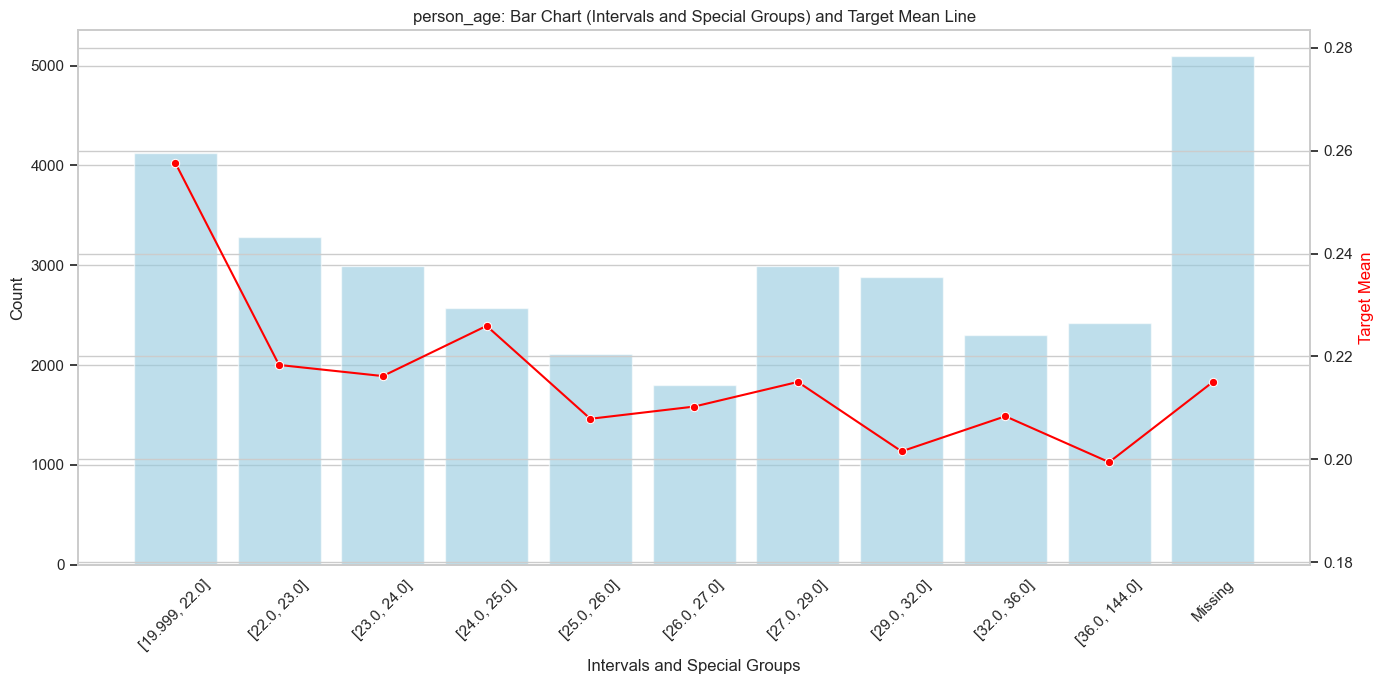

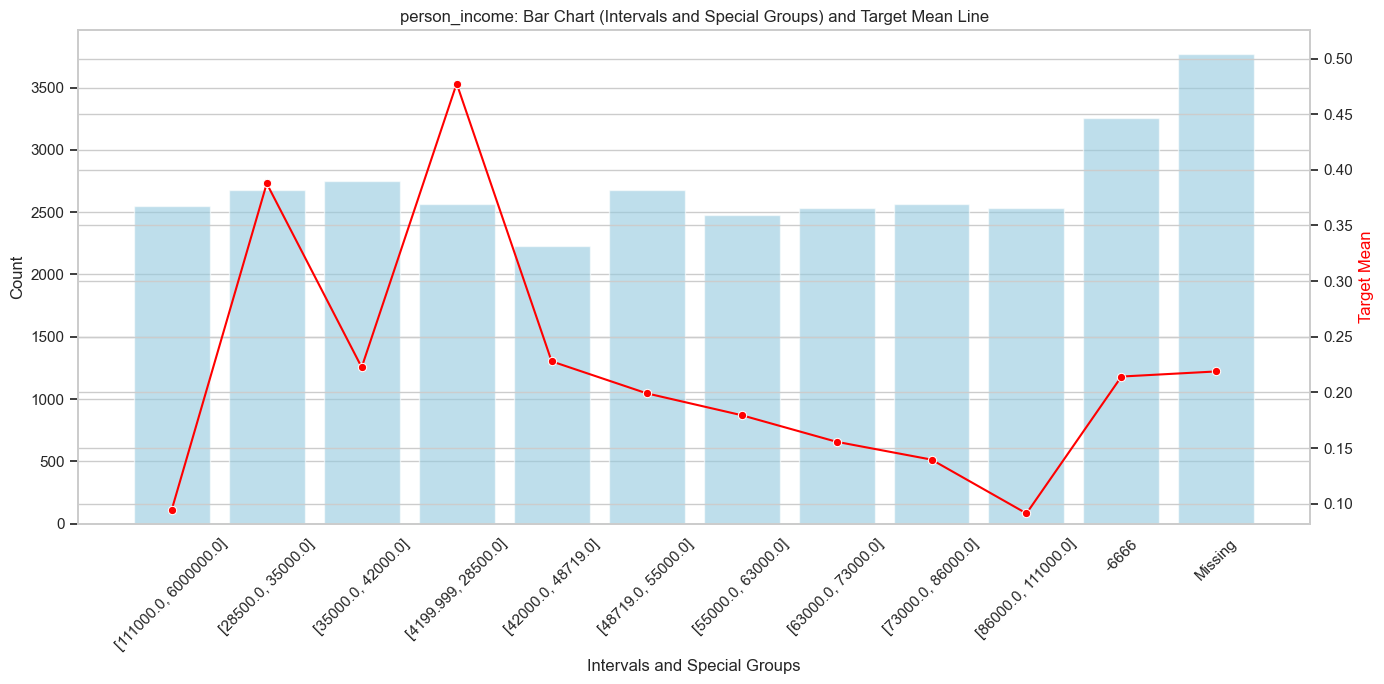

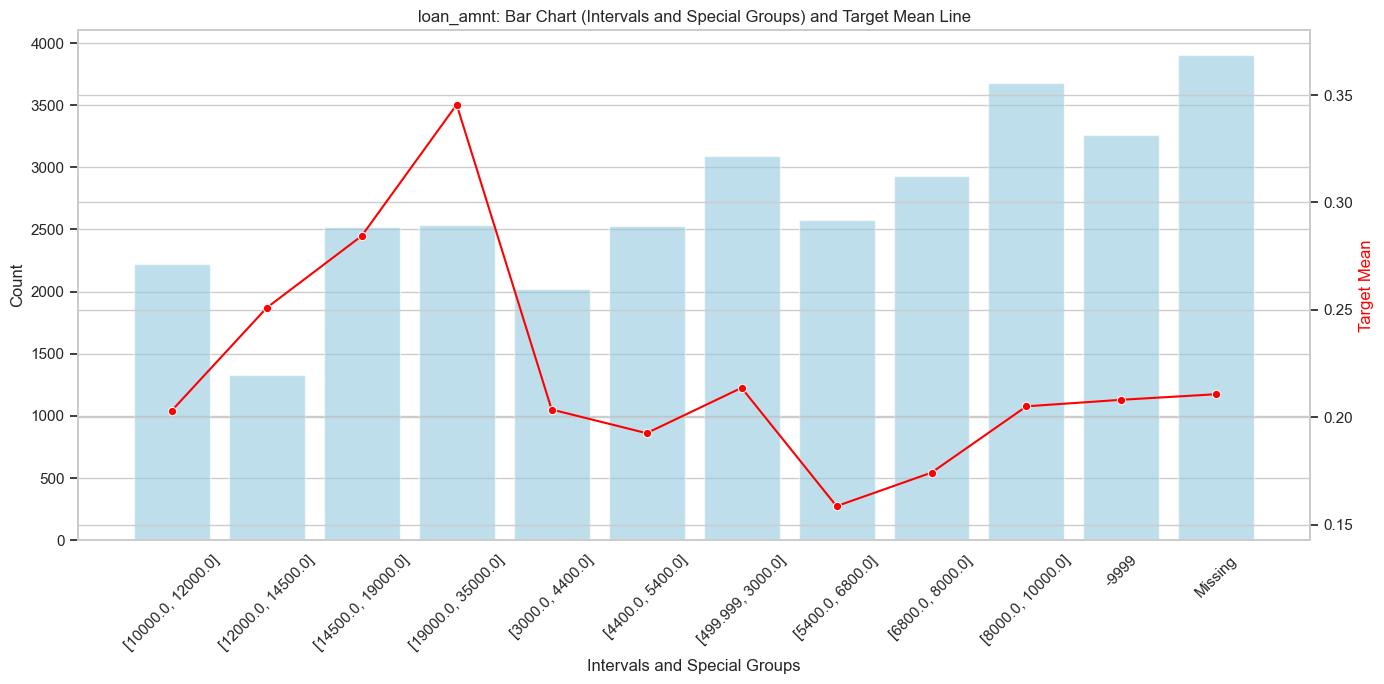

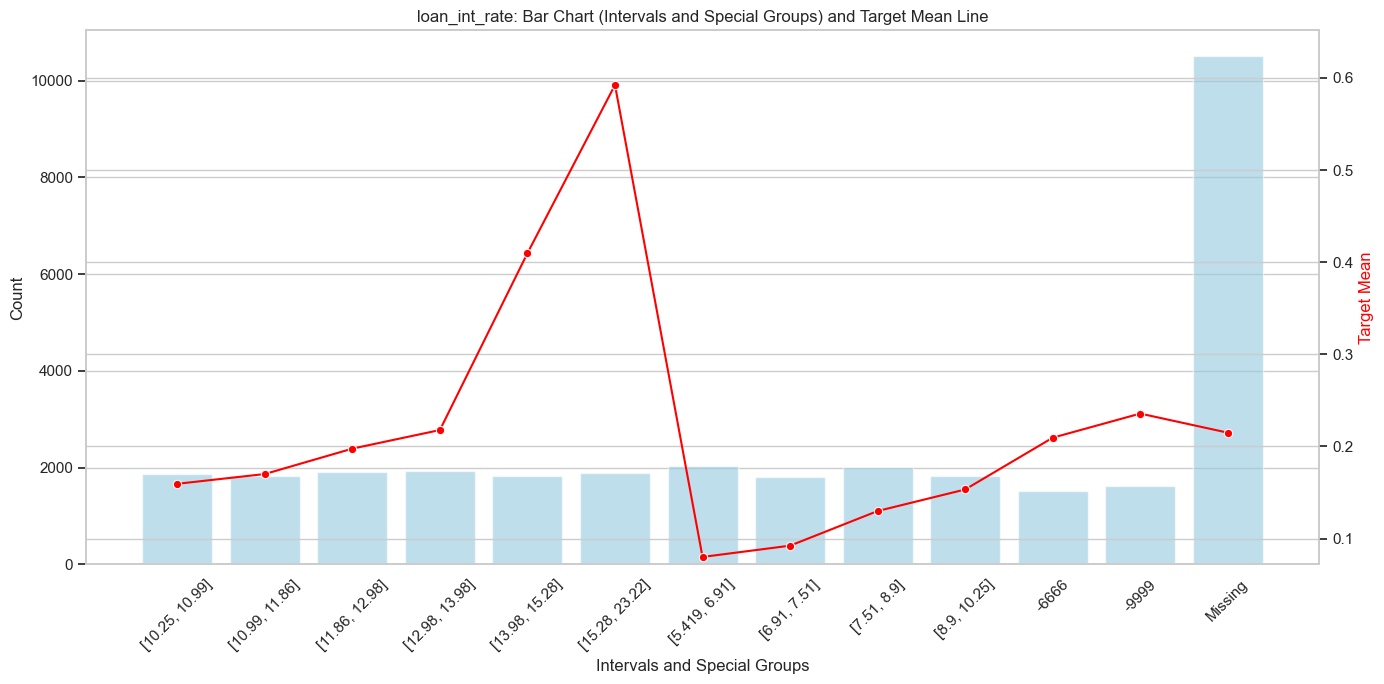

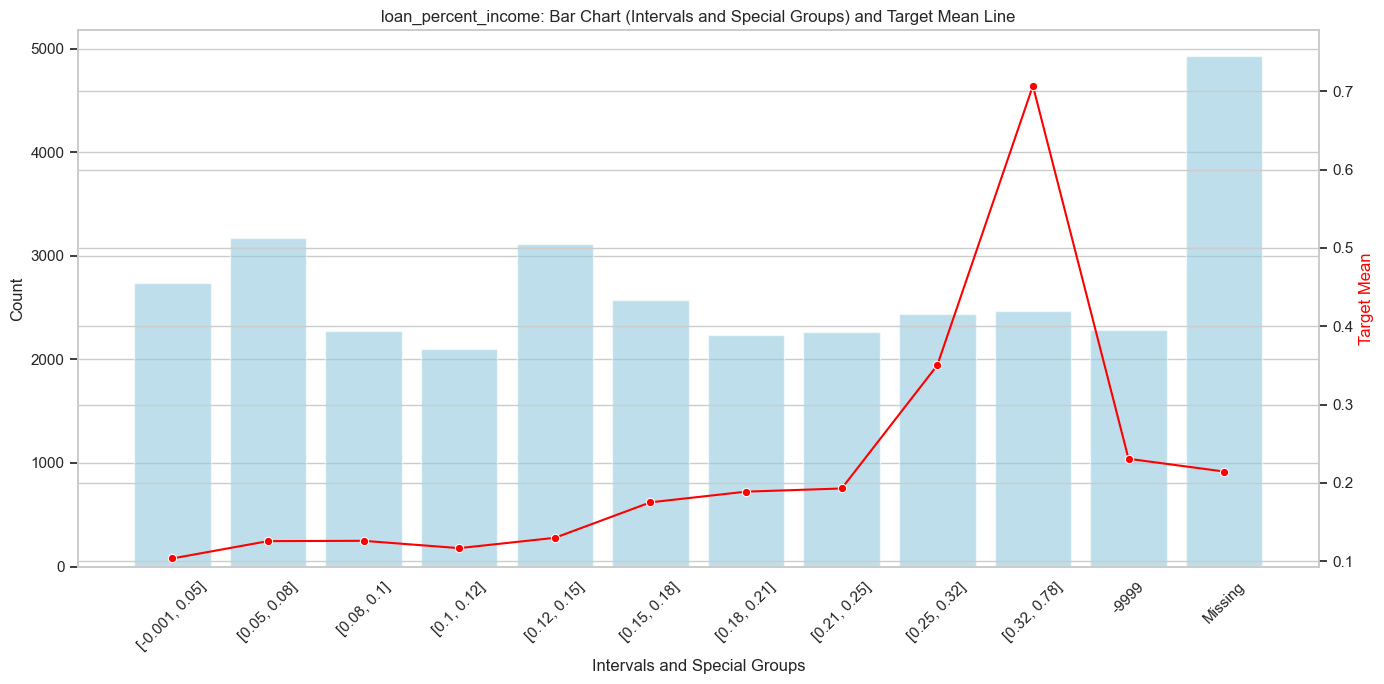

In [9]:
plot_bivariate_with_specials(df, num_columns, 'loan_status', [-6666, -9999])

## 1. Monotonicity-constrained optimal binning

This section identifies optimal cutoff points for numerical variables based on monotonicity constraints and predictive strength (e.g., Gini impurity or Information Value). Missing and special values are handled separately to ensure accurate binning.

### 1.1. Generate the power set of optimal cut points

Identifies optimal cut points for a given variable using a decision tree classifier with a customizable maximum depth. The tree uses the Gini impurity criterion to determine the splits. The function generates a power set (excluding the empty set) of all cut points identified by the tree.

In [10]:
dict_powerset = {}

for var in num_columns:
    powerset = get_powerset_cut_points(df, var, 'loan_status', [-6666, -9999])
    dict_powerset[var] = powerset

dict_powerset

{'person_age': [{28.5},
  {20.5},
  {21.5},
  {22.5},
  {20.5, 28.5},
  {21.5, 28.5},
  {22.5, 28.5},
  {20.5, 21.5},
  {20.5, 22.5},
  {21.5, 22.5},
  {20.5, 21.5, 28.5},
  {20.5, 22.5, 28.5},
  {21.5, 22.5, 28.5},
  {20.5, 21.5, 22.5},
  {20.5, 21.5, 22.5, 28.5}],
 'person_income': [{16160.0},
  {28994.5},
  {58572.5},
  {59636.5},
  {34999.5},
  {79994.0},
  {19996.0},
  {16160.0, 28994.5},
  {16160.0, 58572.5},
  {16160.0, 59636.5},
  {16160.0, 34999.5},
  {16160.0, 79994.0},
  {16160.0, 19996.0},
  {28994.5, 58572.5},
  {28994.5, 59636.5},
  {28994.5, 34999.5},
  {28994.5, 79994.0},
  {19996.0, 28994.5},
  {58572.5, 59636.5},
  {34999.5, 58572.5},
  {58572.5, 79994.0},
  {19996.0, 58572.5},
  {34999.5, 59636.5},
  {59636.5, 79994.0},
  {19996.0, 59636.5},
  {34999.5, 79994.0},
  {19996.0, 34999.5},
  {19996.0, 79994.0},
  {16160.0, 28994.5, 58572.5},
  {16160.0, 28994.5, 59636.5},
  {16160.0, 28994.5, 34999.5},
  {16160.0, 28994.5, 79994.0},
  {16160.0, 19996.0, 28994.5},
  {16160

### 1.2. Obtain only the sets of cuts with monotonic trends

Detects the set of cut points for wich the default rate trend is monotonic (either increasing or decreasing) across the bins generated by each set of cut points.

In [11]:
dict_increasing_cuts = dict()
dict_decreasing_cuts = dict()
dict_dict_monotony = dict()

for var in num_columns:
    increasing_cuts, decreasing_cuts, dict_monotony = get_monotonic_cuts(
        df = df,
        variable = var,
        target = 'loan_status',
        powerset = dict_powerset[var],
        special_values = [-6666, -9999]
        )
    dict_increasing_cuts[var] = increasing_cuts
    dict_decreasing_cuts[var] = decreasing_cuts
    dict_dict_monotony[var] = dict_monotony


Results for Variable: person_age
----------------------------------------
Monotonic increasing cuts: 1
Monotonic decreasing cuts: 7


Results for Variable: person_income
----------------------------------------
Monotonic increasing cuts: 0
Monotonic decreasing cuts: 77


Results for Variable: loan_amnt
----------------------------------------
Monotonic increasing cuts: 38
Monotonic decreasing cuts: 0


Results for Variable: loan_int_rate
----------------------------------------
Monotonic increasing cuts: 95
Monotonic decreasing cuts: 0


Results for Variable: loan_percent_income
----------------------------------------
Monotonic increasing cuts: 127
Monotonic decreasing cuts: 0



### 1.3. Obtain valid sets of cut points

Identifies valid sets of cut points that satify a desired monotonicity and ensure each bin contains at least a specified percentage (5%) of records.

In [12]:
force_monotony = {
    'person_age': 'decreasing',
    'person_income': 'decreasing',
    'loan_amnt': 'increasing',
    'loan_int_rate': 'increasing',
    'loan_percent_income': 'increasing'
}

dict_valid_cuts = {}

for var in num_columns:
    valid_cuts = get_valid_cuts(
        df = df,
        variable = var,
        cuts_increasing = dict_increasing_cuts[var], 
        cuts_decreasing = dict_decreasing_cuts[var],
        special_values = [-6666, -9999],
        monotony = force_monotony[var]
    )
    
    dict_valid_cuts[var] = valid_cuts


Processing Variable: person_age
----------------------------------------
Valid cuts identified for variable person_age: 1 sets.


Processing Variable: person_income
----------------------------------------
Valid cuts identified for variable person_income: 2 sets.


Processing Variable: loan_amnt
----------------------------------------
Valid cuts identified for variable loan_amnt: 3 sets.


Processing Variable: loan_int_rate
----------------------------------------
Valid cuts identified for variable loan_int_rate: 3 sets.


Processing Variable: loan_percent_income
----------------------------------------
Valid cuts identified for variable loan_percent_income: 1 sets.



In [13]:
dict_valid_cuts

{'person_age': [[22.5, 28.5]],
 'person_income': [[28994.5, 34999.5, 58572.5, 79994.0],
  [28994.5, 34999.5, 59636.5, 79994.0]],
 'loan_amnt': [[12262.5, 18087.5], [12237.5, 18087.5], [14487.5, 18087.5]],
 'loan_int_rate': [[7.744999885559082,
   9.635000228881836,
   12.724999904632568,
   14.365000247955322],
  [7.744999885559082,
   9.635000228881836,
   12.724999904632568,
   15.275000095367432],
  [7.744999885559082,
   9.635000228881836,
   12.724999904632568,
   14.634999752044678]],
 'loan_percent_income': [[0.07499999925494194,
   0.1550000011920929,
   0.2549999952316284,
   0.3050000071525574]]}

The following cells are used to identify variables for which no valid cutoff points were found, no monotonic cutoff points exist, monotonicity needs to be specified (if not done previously), or no points with the desired monotonicity were found. In such cases, you may want to attempt finding valid cutoff points with the opposite monotonicity.

In [14]:
no_valid_vars = [key for key, value in dict_valid_cuts.items() if isinstance(value, list) and not value]

no_valid_vars

[]

In [15]:
vars_discard = [key for key, value in dict_valid_cuts.items() if isinstance(value, str) and 'discard' in value]

vars_discard

[]

In [16]:
vars_specify_monotony = [key for key, value in dict_valid_cuts.items() if isinstance(value, str) and 'specify_monotony' in value]

vars_specify_monotony

[]

In [17]:
vars_try_decreasing = [key for key, value in dict_valid_cuts.items() if isinstance(value, str) and 'try_decreasing' in value]

vars_try_decreasing

[]

In [18]:
vars_try_increasing = [key for key, value in dict_valid_cuts.items() if isinstance(value, str) and 'try_increasing' in value]

vars_try_increasing

[]

In [19]:
# We remove the keys that do not have valid cutoffs and those without monotonic cutoffs.
for invalid_var in (no_valid_vars + vars_discard):
    del dict_valid_cuts[invalid_var]

dict_valid_cuts

{'person_age': [[22.5, 28.5]],
 'person_income': [[28994.5, 34999.5, 58572.5, 79994.0],
  [28994.5, 34999.5, 59636.5, 79994.0]],
 'loan_amnt': [[12262.5, 18087.5], [12237.5, 18087.5], [14487.5, 18087.5]],
 'loan_int_rate': [[7.744999885559082,
   9.635000228881836,
   12.724999904632568,
   14.365000247955322],
  [7.744999885559082,
   9.635000228881836,
   12.724999904632568,
   15.275000095367432],
  [7.744999885559082,
   9.635000228881836,
   12.724999904632568,
   14.634999752044678]],
 'loan_percent_income': [[0.07499999925494194,
   0.1550000011920929,
   0.2549999952316284,
   0.3050000071525574]]}

Run the get_valid_cuts function again when there are variables in try_increasing or try_decreasing. If you want to remove them, execute the following code cell.

In [20]:
#for var in vars_try_decreasing:
#    del dict_valid_cuts[var]
#
#for var in vars_try_increasing:
#    del dict_valid_cuts[var]
#
#dict_valid_cuts

### 1.4. Find the optimal cutoff points

Finds the set of cut points with the desired monotonicity that yields the highest IV. Gives priority to sets of cuts that generate the highest number of bins.

In [21]:
dict_optim_cuts = {}
dict_iv_scores = {}

for var in list(dict_valid_cuts.keys()):
    optim_cuts, iv_scores = get_best_cuts(
        df = df,
        variable = var,
        valid_cuts = dict_valid_cuts[var],
        target = 'loan_status',
        special_values = [-6666, -9999],
        dict_monotony = dict_dict_monotony[var]
    )
    
    dict_optim_cuts[var] = optim_cuts
    dict_iv_scores[var] = iv_scores

In [22]:
dict_optim_cuts

{'person_age': ([22.5, 28.5],
  0.008772058499821309,
              bin  total  event  non_event  event_rate  non_event_rate  \
  0  [-inf, 22.5)   4122   1062       3060    0.149409        0.120127   
  1  [22.5, 28.5)  14326   3118      11208    0.438661        0.439995   
  2   [28.5, inf)   9036   1832       7204    0.257738        0.282809   
  3       Missing   5097   1096       4001    0.154192        0.157068   
  
     default_rate       woe        iv    monotony  
  0      0.257642 -0.218137  0.006387  decreasing  
  1      0.217646  0.003038  0.000004  decreasing  
  2      0.202745  0.092830  0.002327  decreasing  
  3      0.215028  0.018479  0.000053  decreasing  ),
 'person_income': ([28994.5, 34999.5, 59636.5, 79994.0],
  0.3933222919002625,
                    bin  total  event  non_event  event_rate  non_event_rate  \
  0     [-inf, 28994.5)   2700   1254       1446    0.176421        0.056766   
  1  [28994.5, 34999.5)   2234    961       1273    0.135200        0.04

## 2. Assign WoE values

### 2.1. Numerical variables

In [23]:
for var in dict_optim_cuts.keys():
    df = woe_transform(df, var, [-6666,-9999], dict_optim_cuts[var])

In [24]:
df.columns

Index(['person_age', 'person_income', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file', 'loan_grade',
       'person_home_ownership', 'loan_intent', 'loan_status', 'woe_person_age',
       'woe_person_income', 'woe_loan_amnt', 'woe_loan_int_rate',
       'woe_loan_percent_income'],
      dtype='object')

### 2.2. Categorical variables

In [25]:
dict_iv_cat = {}
dict_resume_cat = {}

for var in cat_columns:
    iv_cat, resume_cat = calculate_iv(
        df,
        var,
        'loan_status'
    )

    dict_iv_cat[var] = iv_cat
    dict_resume_cat[var] = resume_cat

    woe_dict = resume_cat.set_index(var)['woe'].to_dict()
    df['woe_' + var] = df[var].map(woe_dict)

In [26]:
df.columns

Index(['person_age', 'person_income', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file', 'loan_grade',
       'person_home_ownership', 'loan_intent', 'loan_status', 'woe_person_age',
       'woe_person_income', 'woe_loan_amnt', 'woe_loan_int_rate',
       'woe_loan_percent_income', 'woe_cb_person_default_on_file',
       'woe_loan_grade', 'woe_person_home_ownership', 'woe_loan_intent'],
      dtype='object')

## 3. Generate WoE value plots

### 3.1. Numerical variables

In [27]:
output_pdf_path = './woe_num_vars.pdf'

with PdfPages(output_pdf_path) as pdf:
    for variable, data in dict_optim_cuts.items():
        df_bins_woe = data[2]
        
        plt.figure(figsize=(10,5))
        sns.barplot(x='bin', y='woe', data=df_bins_woe, palette='mako')
        
        plt.title(f'WOE visualization for: {variable}')
        plt.xlabel(variable)
        plt.ylabel('woe')
        plt.xticks(rotation=10)

        pdf.savefig()
        plt.close()

print(f"The plots have been saved in the file: {output_pdf_path}")

The plots have been saved in the file: ./woe_num_vars.pdf


In [28]:
output_pdf_path = './woe_vars_cat.pdf'

with PdfPages(output_pdf_path) as pdf:
    for variable, data in dict_resume_cat.items():
        df_bins_woe = data
        
        plt.figure(figsize=(10,5))
        sns.barplot(x=variable, y='woe', data=df_bins_woe, palette='mako')
        
        plt.title(f'WOE visualization for: {variable}')
        plt.xlabel(variable)
        plt.ylabel('woe')
        
        plt.xticks(rotation=10)
        
        pdf.savefig()
        plt.close()

print(f"The plots have been saved in the file: {output_pdf_path}")

The plots have been saved in the file: ./woe_vars_cat.pdf


## 4. Generate final summary

In [29]:
res_num = []

for var in dict_optim_cuts.keys():
    df_iter = dict_optim_cuts[var][-1]
    # Se agrega la columna "variable"
    df_iter['variable'] = var
    res_num.append(df_iter)

res_cat = []

for var in dict_resume_cat.keys():
    df_iter = dict_resume_cat[var]
    df_iter.rename(columns={var: 'bin'}, inplace=True)
    df_iter['variable'] = var
    res_cat.append(df_iter)

In [30]:
order_columns = [
    'variable',
    'bin',
    'total',
    'event',
    'non_event',
    'event_rate',
    'non_event_rate',
    'default_rate',
    'woe',
    'iv',
    'monotony'
]

df_num = pd.concat([df_ for df_ in res_num])
df_num = df_num[order_columns]

df_cat = pd.concat([df_ for df_ in res_cat])
df_cat = df_cat[order_columns]

df_res = pd.concat([df_num, df_cat])
df_res

,variable,bin,total,event,non_event,event_rate,non_event_rate,default_rate,woe,iv,monotony
0,person_age,"[-inf, 22.5)",4122,1062,3060,0.149409,0.120127,0.257642,-0.218137,0.006387,decreasing
1,person_age,"[22.5, 28.5)",14326,3118,11208,0.438661,0.439995,0.217646,0.003038,0.000004,decreasing
2,person_age,"[28.5, inf)",9036,1832,7204,0.257738,0.282809,0.202745,0.092830,0.002327,decreasing
3,person_age,Missing,5097,1096,4001,0.154192,0.157068,0.215028,0.018479,0.000053,decreasing
0,person_income,"[-inf, 28994.5)",2700,1254,1446,0.176421,0.056766,0.464444,-1.133935,0.135681,decreasing
1,person_income,"[28994.5, 34999.5)",2234,961,1273,0.135200,0.049974,0.430170,-0.995241,0.084820,decreasing
2,person_income,"[34999.5, 59636.5)",8959,1966,6993,0.276590,0.274526,0.219444,-0.007490,0.000015,decreasing
3,person_income,"[59636.5, 79994.0)",5329,825,4504,0.116066,0.176815,0.154813,0.420940,0.025571,decreasing
4,person_income,"[79994.0, inf)",6331,579,5752,0.081458,0.225808,0.091455,1.019602,0.147180,decreasing
5,person_income,Missing,3770,825,2945,0.116066,0.115613,0.218833,-0.003917,0.000002,decreasing


In [31]:
df_res.to_excel('./summary_woe.xlsx', sheet_name='Summary WoE', index = False)

---

In [32]:
!pip freeze > requirements.txt